In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('airquality.csv')
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [2]:
df = df[['Ozone', 'Temp']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Ozone,Temp
0,41.0,67
1,36.0,72
2,12.0,74
3,18.0,62
4,28.0,66
...,...,...
111,14.0,63
112,30.0,70
113,14.0,75
114,18.0,76


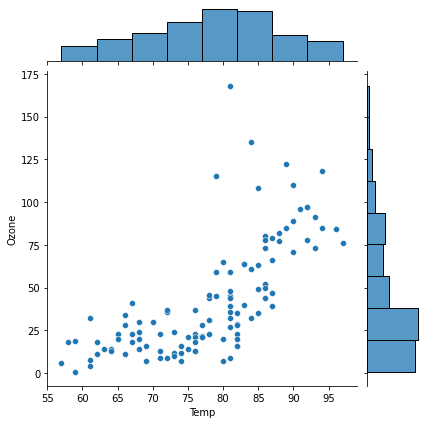

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(x=df['Temp'], y=df['Ozone'], kind='scatter', cmap="viridis")
plt.show()


In [4]:
from bigsimr import cor_fast

rho = cor_fast(df.values, method = "pearson")
rho

array([[1.        , 0.69836034],
       [0.69836034, 1.        ]])

In [5]:
ozone = df['Ozone'].values
print('Ozone summary: logmean = {0:.2f}, logsd = {1:.2f}'.format(
    np.mean(np.log(ozone)), 
    np.std(np.log(ozone))
))

temp = df['Temp'].values
print('Temperature summary: mean = {0:.2f}, sd = {1:.2f}'.format(
    np.mean(temp), 
    np.std(temp)
))

Ozone summary: logmean = 3.42, logsd = 0.86
Temperature summary: mean = 77.87, sd = 9.44


In [6]:
from scipy.stats import norm, lognorm

#lognorm s = logsd, scale = exp(logmean)
margins = [
  lognorm(s=0.86, scale=np.exp(3.42)),
  norm(loc=77.87, scale=9.44)
]

In [7]:
from bigsimr import cor_bounds
rho_lower, rho_upper = cor_bounds(margins=margins, type="pearson")
print("Lower bound:")
print(rho_lower)
print("Upper bound:")
print(rho_upper)

Lower bound:
[[ 1.         -0.81829693]
 [-0.81829693  1.        ]]
Upper bound:
[[1.         0.81935394]
 [0.81935394 1.        ]]


In [8]:
from bigsimr import rvec
np.random.seed(1)

rv = rvec(10000, rho, margins)

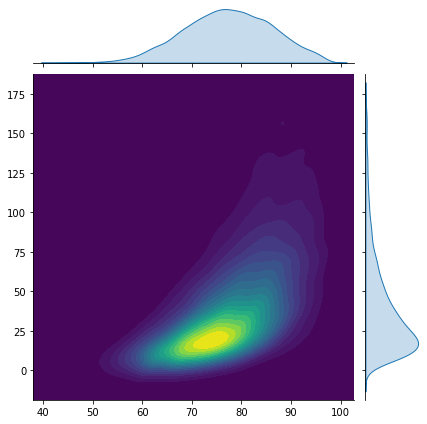

In [9]:
rv = rv[(rv[:,0]>0) & (rv[:,0]<ozone.max()) & (rv[:,1]>0) & (rv[:,1]<temp.max()), :]

sns.jointplot(x=rv[:,1], y=rv[:,0], kind='kde', cmap="viridis", fill=True, thresh=0, levels=20)
plt.show()

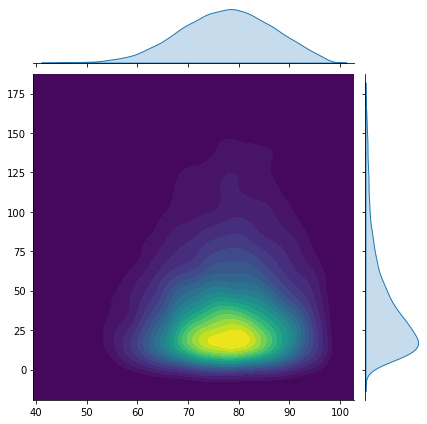

In [10]:
np.random.seed(1)
rv = np.stack([
    lognorm.rvs(size=10000, s=0.86, scale=np.exp(3.42)),
    norm.rvs(size=10000, loc=77.87, scale=9.44)
], 1)

rv = rv[(rv[:,0]>0) & (rv[:,0]<ozone.max()) & (rv[:,1]>0) & (rv[:,1]<temp.max()), :]

sns.jointplot(x=rv[:,1], y=rv[:,0], kind='kde', cmap="viridis", fill=True, thresh=0, levels=20)
plt.show()
